## Email-Spam-Classification
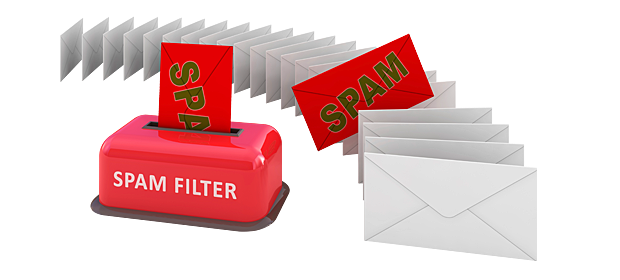

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as ex

import nltk

### Data Preparation

In [2]:
df = pd.read_csv(r'spam.csv',encoding = "ISO-8859-1")

In [3]:
df = df.iloc[:,:2]

In [4]:
df.rename(columns={'v1':'target','v2':'text'},inplace=True)

In [5]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [6]:
df.duplicated().sum()

403

In [7]:
df.drop_duplicates(keep='first',inplace=True)

In [8]:
df.duplicated().sum()

0

In [9]:
df['target'] = df['target'].map({'ham':0,'spam':1})

In [10]:
df.head(5)

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### EDA

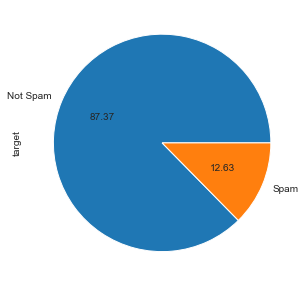

In [11]:
sns.set_style(style='darkgrid')
plt.figure(figsize=(10,5))
df['target'].value_counts().plot(kind='pie',autopct='%0.2f',labels=['Not Spam','Spam'])
plt.show()

<AxesSubplot:>

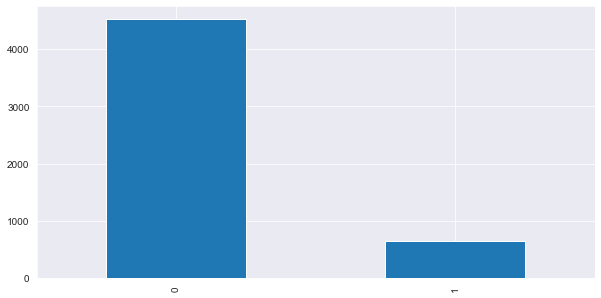

In [12]:
sns.set_style(style='darkgrid')
plt.figure(figsize=(10,5))
df['target'].value_counts().plot(kind='bar')

In [13]:
# Data is inbalanced

we have more than 10k not sapm sample.

In [14]:
df['num_char'] = df['text'].apply(len)
df['num_word'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentence']  = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [15]:
df.head(5)

,target,text,num_char,num_word,num_sentence
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [16]:
df.describe().drop('target',axis=1)

,num_char,num_word,num_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455407,1.961308
std,58.236293,13.322448,1.432583
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [17]:
#ham
df[df['target'] == 0][['num_char','num_word','num_sentence']].describe()

,num_char,num_word,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123339,1.815545
std,56.358207,13.491315,1.364098
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [18]:
#spam
df[df['target'] == 1][['num_char','num_word','num_sentence']].describe()

,num_char,num_word,num_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.969372
std,30.137753,7.008418,1.488910
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<AxesSubplot:>

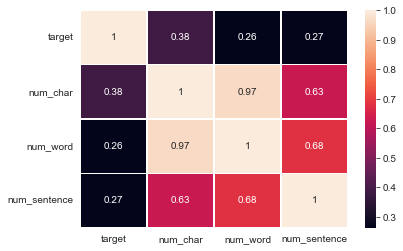

In [19]:
sns.heatmap(df.corr(),annot=True,linewidths=.5)

### Data Preprocessing
- Lower case
- Tokenization
- Removing Special Character
- Removing Punctution
- Removing Stopword
- Stemming

In [20]:
import string
import re
punct = string.punctuation
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

In [21]:
ps =  PorterStemmer()
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    #puctuation
    l = []
    for word in text:
        if word.isalnum():
            l.append(word)
    
    #stopword
    text = l[:]
    l.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in punct:
            l.append(i)
    
    #stemming
    text = l[:]
    l.clear()
    for i in text:
        l.append(ps.stem(i))
    text = " ".join(l)
    
    text = TextBlob(text)
    text = text.correct()
    return text.raw

In [22]:
%%time
df['trans_text'] = df['text'].apply(transform_text)

Wall time: 36min 36s


In [24]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

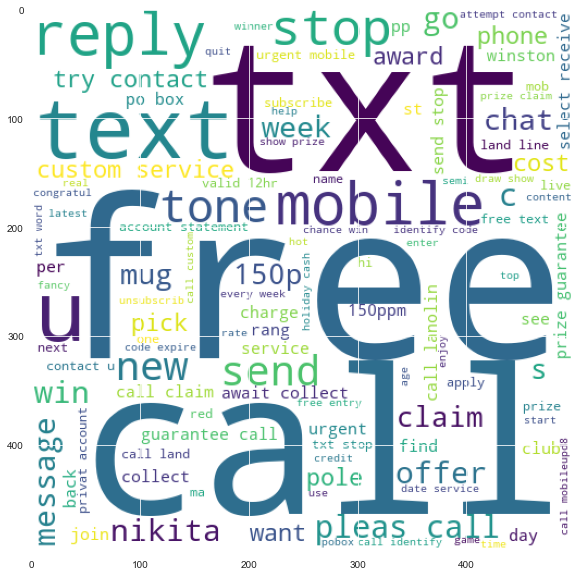

In [25]:
#Spam most frequents word
spam_wc = wc.generate(df[df['target'] == 1]['trans_text'].str.cat(sep=" "))
plt.figure(figsize=(15,10))
plt.imshow(spam_wc)

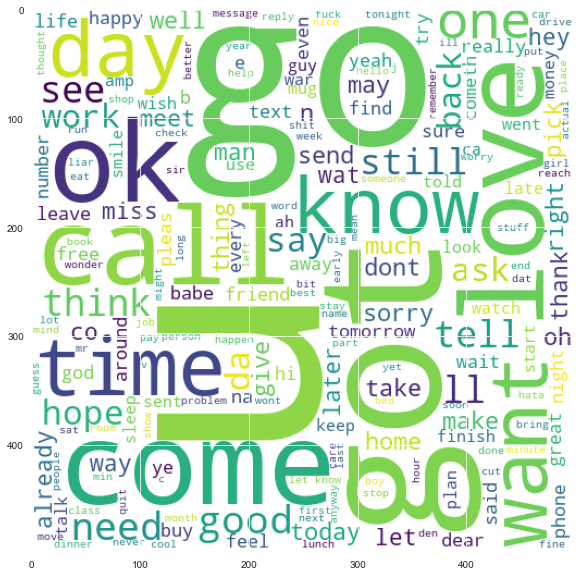

In [26]:
#ham most frequent words
spam_wc = wc.generate(df[df['target'] == 0]['trans_text'].str.cat(sep=" "))
plt.figure(figsize=(15,10))
plt.imshow(spam_wc)

In [27]:
#extracting top 30 words in spam
spam_corpus = []
for msg in df[df['target'] == 1]['trans_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [28]:
len(spam_corpus)

9939

In [29]:
from collections import Counter

Text(0, 0.5, 'Count')

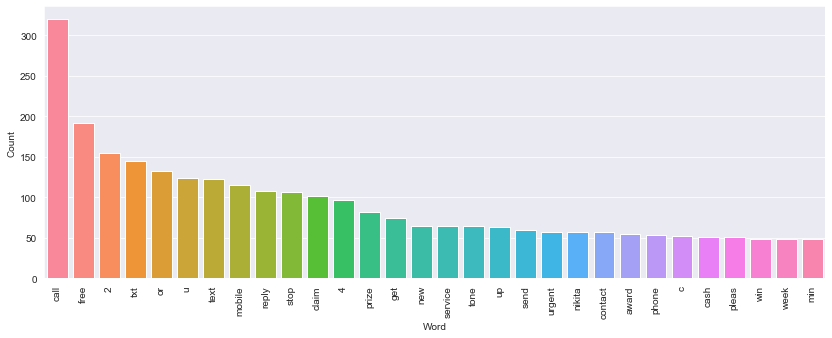

In [30]:
x = pd.DataFrame(Counter(spam_corpus).most_common(30))[0]
y = pd.DataFrame(Counter(spam_corpus).most_common(30))[1]
plt.figure(figsize=(14,5))
plt.xticks(rotation='vertical')
sns.set(font_scale=1.5)
sns.barplot(x=x,y=y, saturation=1)
plt.xlabel('Word')
plt.ylabel('Count')

In [31]:
#extracting top 30 words in ham
ham_corpus = []
for msg in df[df['target'] == 0]['trans_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

Text(0, 0.5, 'Count')

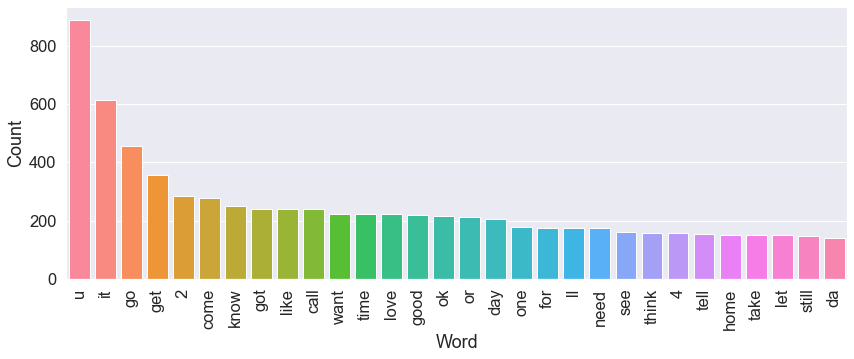

In [32]:
x = pd.DataFrame(Counter(ham_corpus).most_common(30))[0]
y = pd.DataFrame(Counter(ham_corpus).most_common(30))[1]
plt.figure(figsize=(14,5))
plt.xticks(rotation='vertical')
sns.set(font_scale=1.5)
sns.barplot(x=x,y=y, saturation=1)
plt.xlabel('Word')
plt.ylabel('Count')

### Model Building

In [59]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix

In [60]:
tfi = TfidfVectorizer(max_features=1200)

TypeError: 'module' object is not callable

In [35]:
x_trasnformed = tfi.fit_transform(df['text']).toarray()

In [36]:
y = df['target']

In [37]:
acc = 0
prec = 0
r_s = 0
for i in range(1,101):
    X_train,X_test,y_train,y_test = train_test_split(x_trasnformed,y,test_size=0.2,random_state=i)
    gb = BernoulliNB()  

    gb.fit(X_train,y_train)
    y_pred = gb.predict(X_test)
    if prec<=precision_score(y_test,y_pred):
        prec = precision_score(y_test,y_pred)
        acc = accuracy_score(y_test,y_pred)
        r_s = i

In [38]:
acc,prec,r_s

(0.9874274661508704, 1.0, 92)

In [39]:
X_train,X_test,y_train,y_test = train_test_split(x_trasnformed,y,test_size=0.2,random_state=12)

In [40]:
gb  = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB() 

In [41]:
gb.fit(X_train,y_train)

GaussianNB()

In [42]:
y_pred = gb.predict(X_test)

In [43]:
print('GausianNb:')
print('Accuracy = ',accuracy_score(y_test,y_pred))
print('confusion matrix=\n',confusion_matrix(y_test,y_pred))
print('Precesion score = ',precision_score(y_test,y_pred))

GausianNb:
Accuracy =  0.844294003868472
confusion matrix=
 [[762 146]
 [ 15 111]]
Precesion score =  0.43190661478599224


In [44]:
#MultinomialNB
mnb.fit(X_train,y_train)

MultinomialNB()

In [45]:
y_pred = mnb.predict(X_test)

In [46]:
print('MultinomialNB:')
print('Accuracy = ',accuracy_score(y_test,y_pred))
print('confusion matrix=\n',confusion_matrix(y_test,y_pred))
print('Precesion score = ',precision_score(y_test,y_pred))

MultinomialNB:
Accuracy =  0.9835589941972921
confusion matrix=
 [[908   0]
 [ 17 109]]
Precesion score =  1.0


In [47]:
#BernoulliNB
bnb.fit(X_train,y_train)

BernoulliNB()

In [48]:
y_pred = bnb.predict(X_test)

In [49]:
print('BernoulliNB:')
print('Accuracy = ',accuracy_score(y_test,y_pred))
print('confusion matrix=\n',confusion_matrix(y_test,y_pred))
print('Precesion score = ',precision_score(y_test,y_pred))

BernoulliNB:
Accuracy =  0.9912959381044487
confusion matrix=
 [[908   0]
 [  9 117]]
Precesion score =  1.0


### Trying Diff models

In [50]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [51]:
svc = SVC(kernel='sigmoid',gamma=1.0)
dt = DecisionTreeClassifier(max_depth=5)
lr = LogisticRegression(n_jobs=-1)
ex = ExtraTreesClassifier(n_estimators=200,max_depth=5,n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=200,learning_rate=0.2)
rfc = RandomForestClassifier(n_estimators=200,n_jobs=-1,max_depth=5)
ab = AdaBoostClassifier(n_estimators=50,learning_rate=0.2)
bgc = BaggingClassifier(n_estimators=50,n_jobs=-1)
xgb = XGBClassifier(n_estimators=200,n_jobs=-1,learning_rate=0.2,max_depth=5)
lgb = LGBMClassifier(n_estimators=200,n_jobs=-1,learning_rate=0.2,max_depth=5)
gb  = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB() 

In [52]:
def model_eval(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    return accuracy,precision

In [53]:
d={
    "SVC":svc,
    "DecesionTree":dt,
    'LogisticRegression':lr,
    "ExtraatTreeCls":ex,
    "GradientBoosting":gb,
    "RandomForest":rfc,
    "Adaboost":ab,
    "BaggingCls":bgc,
    "XGbcls":xgb,
    "LGBM":lgb,
    "GausianNB":gb,
    "MultinomialNB":mnb,
    "BernauliNB":bnb
}

In [54]:
accu_score = []
prec_score = []
for name,cls in d.items():
    current_acc,current_prec = model_eval(cls,X_train,X_test,y_train,y_test)
    accu_score.append(current_acc)
    prec_score.append(current_prec)

[11:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [55]:
accu_df = pd.DataFrame({'Algo':d.keys(),'accuracy':accu_score,'precesion':prec_score})

In [56]:
accu_df.sort_values(by='precesion',ascending=False)

,Algo,accuracy,precesion
0,SVC,0.990329,1.000000
3,ExtraatTreeCls,0.883946,1.000000
5,RandomForest,0.898453,1.000000
11,MultinomialNB,0.983559,1.000000
12,BernauliNB,0.991296,1.000000
2,LogisticRegression,0.977756,0.990476
6,Adaboost,0.958414,0.977011
9,LGBM,0.983559,0.965812
8,XGbcls,0.979691,0.941176
7,BaggingCls,0.966151,0.895652


In [57]:
#im am chosing MultinomialNB

In [58]:
import pickle
pickle.dump(tfi,open('vectorizer.pkl','wb'))
pickle.dump(bnb,open('model.pkl','wb'))